<hr style="height:2px;border:none"/>
<center><img src="https://upload.wikimedia.org/wikipedia/commons/f/fe/Latam-logo_-v_%28Indigo%29.svg" title="Title text" width="30%" /></center>
<h1 align='center'> Desafío LATAM </h1>

<H4 align='center'> Félix Vergara </H3>

<hr style="height:2px;border:none"/>

In [1]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
#métricas
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.metrics import recall_score
from sklearn.metrics import precision_score
from sklearn.metrics import f1_score
#modelos
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import GridSearchCV
from warnings import filterwarnings 
filterwarnings("ignore")

In [3]:
df = pd.read_csv('/content/gdrive/MyDrive/Desafio LATAM/dataset_SCL.csv')

In [4]:
df.dtypes

Fecha-I      object
Vlo-I        object
Ori-I        object
Des-I        object
Emp-I        object
Fecha-O      object
Vlo-O        object
Ori-O        object
Des-O        object
Emp-O        object
DIA           int64
MES           int64
AÑO           int64
DIANOM       object
TIPOVUELO    object
OPERA        object
SIGLAORI     object
SIGLADES     object
dtype: object

In [5]:
df['Fecha-I'].unique().shape[0]

53252

In [6]:
df['Fecha-O'].unique().shape[0]

62774

# 1. How is the data distributed? Did you find any noteworthy insight to share? What can you conclude about this?

## Distribución de datos

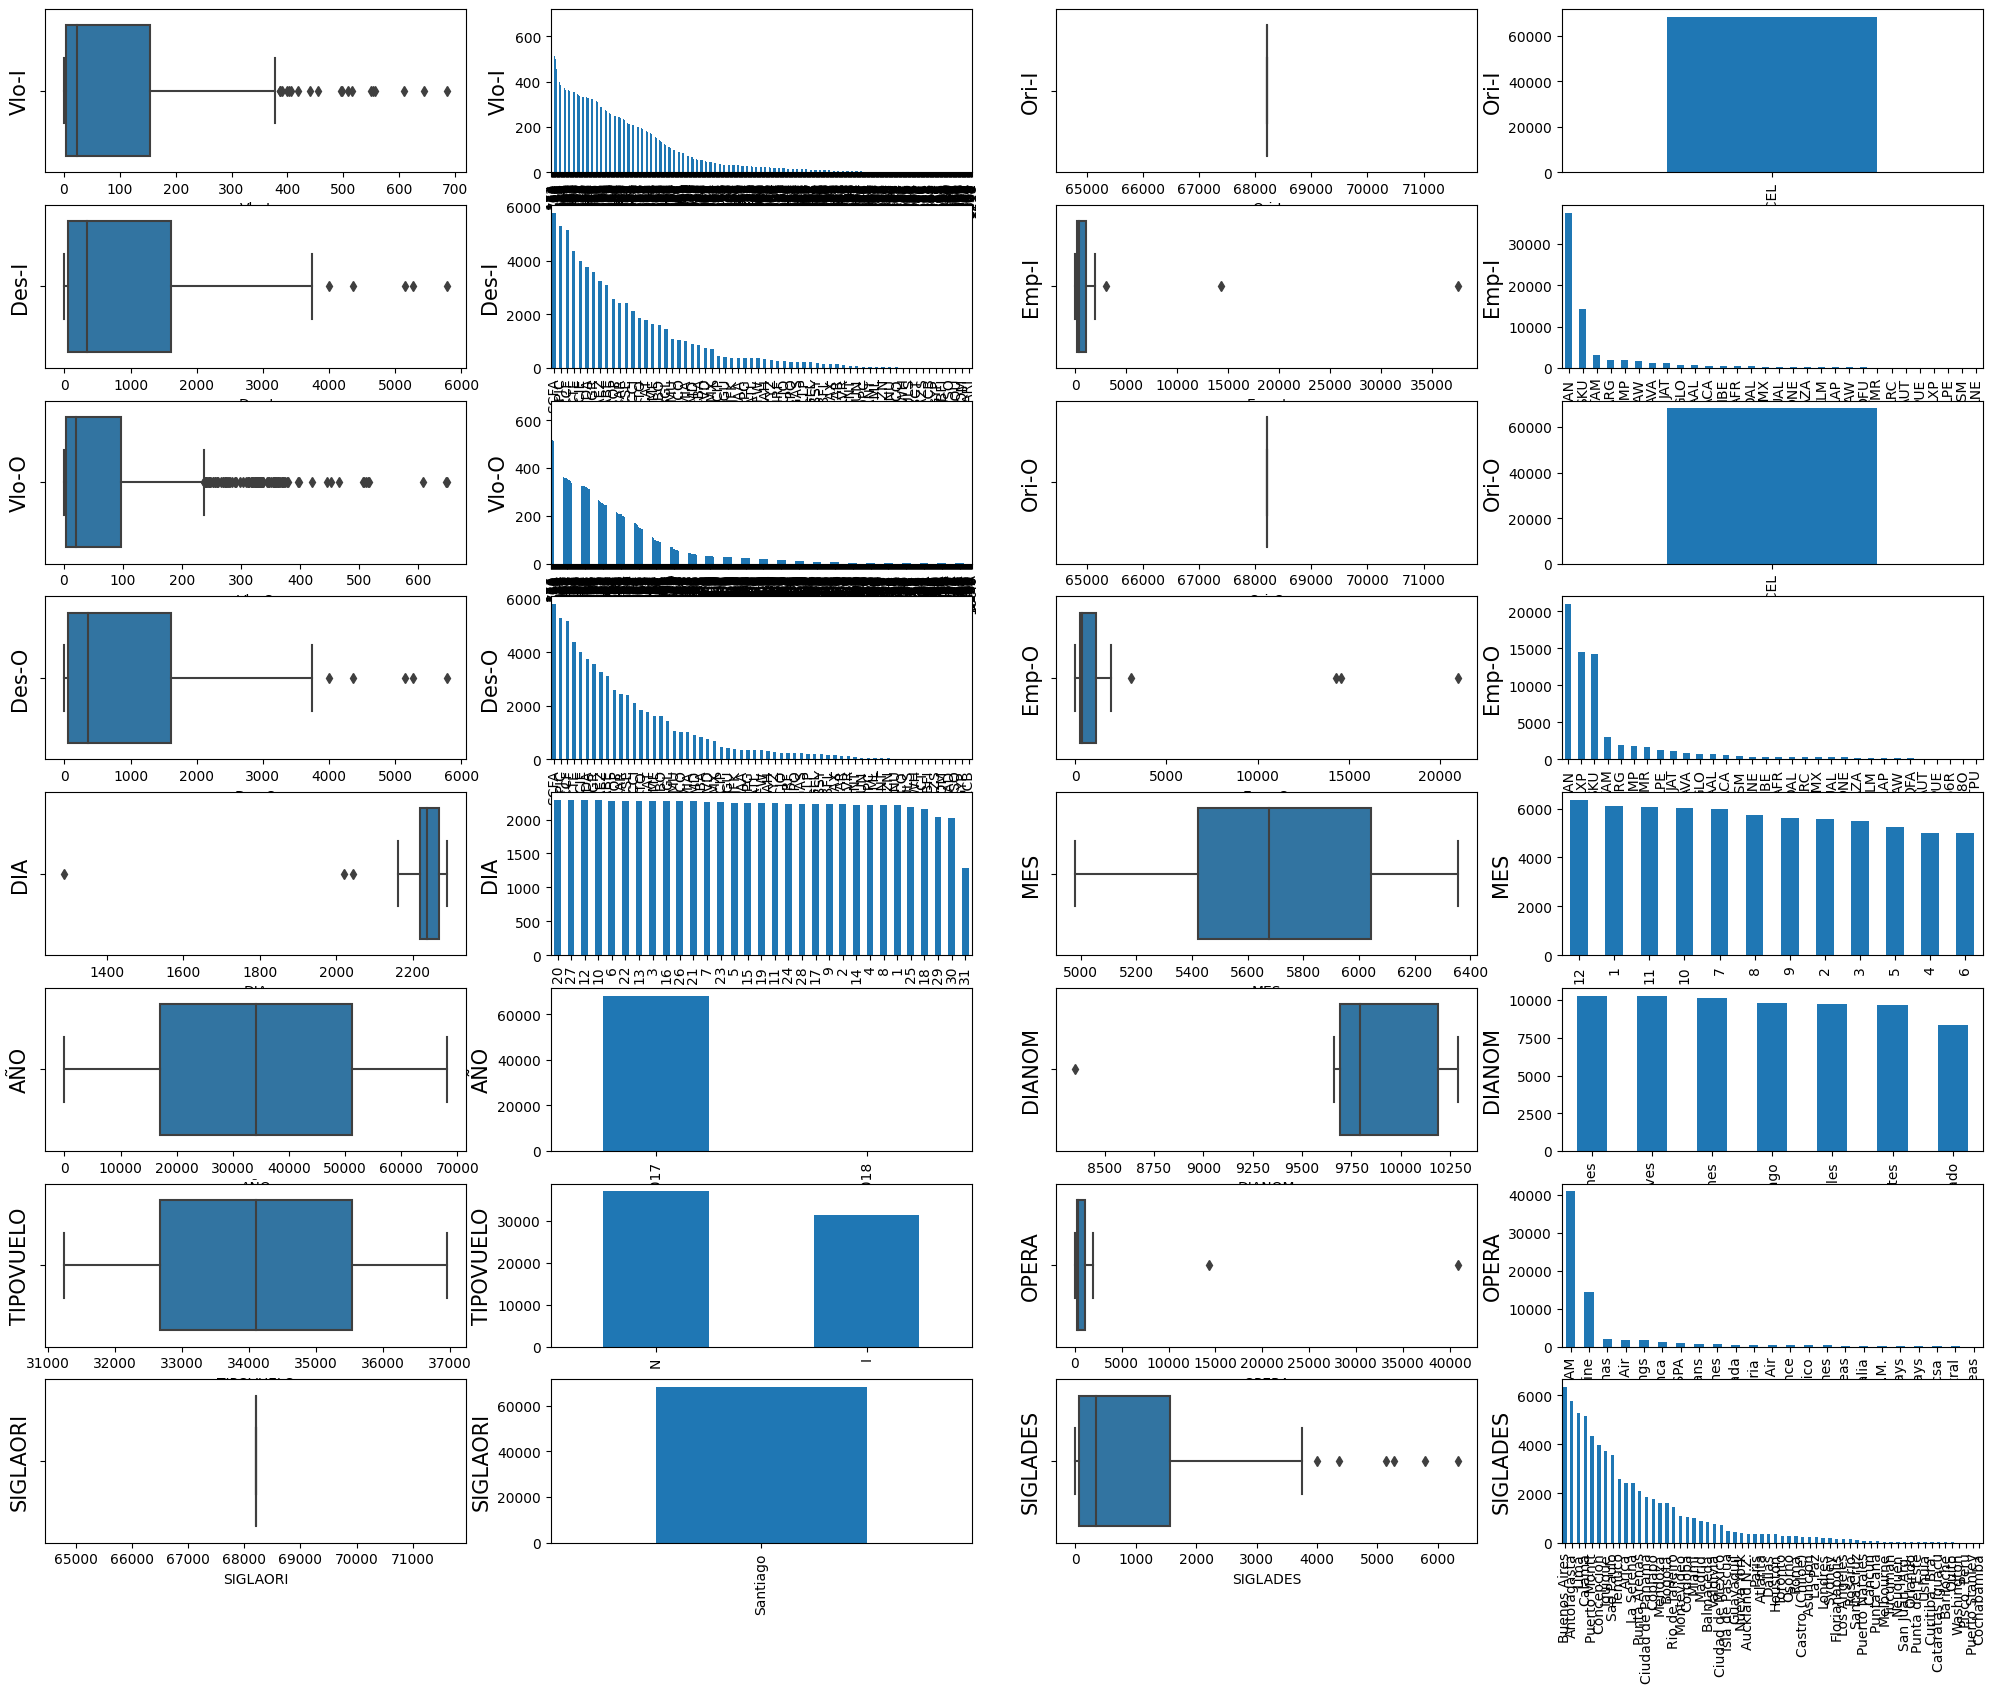

In [7]:
cont_vars = list(df.drop(columns=['Fecha-I','Fecha-O']).columns)
def outliers_visual(data):
    i = 0
    plt.figure(figsize=(25, 25))
    for col in cont_vars:
        i += 1
        plt.subplot(int(df.shape[1]/4)*2+2, 4, i)
        sns.boxplot(x=df[col].value_counts())
        plt.ylabel(col,fontsize=15)
        i += 1
        plt.subplot(int(df.shape[1]/4)*2+2, 4, i)
        df[col].value_counts().plot(kind='bar')
        plt.ylabel(col,fontsize=15)
    plt.show()
outliers_visual(df)

Como podemos observar hay variables no normales dentro de los datos, por lo tanto ejecutaremos un test con las distribuciones más comunes para poder concluir que distribución tiene cada variable

In [8]:
import scipy.stats as st
def get_best_distribution(data):
    dist_names = ["norm", "lognorm", "chi", "gamma", "t", "bernoulli"]
    dist_results = []
    params = {}
    for dist_name in dist_names:
        dist = getattr(st, dist_name)
        try:
          param = dist.fit(data)
        except:
          pass
        params[dist_name] = param
        # Applying the Kolmogorov-Smirnov test
        try:
          D, p = st.kstest(data, dist_name, args=param)
        except:
          D, p = st.chisquare(data)
        print("p value for "+dist_name+" = "+str(p))
        dist_results.append((dist_name, p))

    # select the best fitted distribution
    best_dist, best_p = (max(dist_results, key=lambda item: item[1]))
    # store the name of the best fit and its p value

    print("Best fitting distribution: "+str(best_dist))
    print("Best p value: "+ str(best_p))
    print("Parameters for the best fit: "+ str(params[best_dist]))

    return best_dist, best_p, params[best_dist]

In [9]:
lista_distribucion=[]
for columna in df.drop(columns=['Fecha-I','Fecha-O']).columns:
  columna_distribucion=pd.Series(df[columna].value_counts())
  lista_distribucion.append(get_best_distribution(columna_distribucion))

p value for norm = 2.7312994399315994e-48
p value for lognorm = 6.772060298537835e-130
p value for chi = 2.1949446428996084e-18
p value for gamma = 2.1933462076648823e-18
p value for t = 3.388921568314597e-102
p value for bernoulli = 0.0
Best fitting distribution: chi
Best p value: 2.1949446428996084e-18
Parameters for the best fit: (0.32367060157649796, 0.9999999999999998, 213.0086713725011)
p value for norm = nan
p value for lognorm = 0.04544546156886908
p value for chi = 0.6277776021653181
p value for gamma = 0.7305566487703041
p value for t = 0.7969322009486737
p value for bernoulli = nan
Best fitting distribution: norm
Best p value: nan
Parameters for the best fit: (68206.0, 0.0)
p value for norm = 0.00013292269591661183
p value for lognorm = 6.019078841240487e-11
p value for chi = 0.18274143182463531
p value for gamma = 0.22386729298213104
p value for t = 4.395852632390387e-06
p value for bernoulli = 0.0
Best fitting distribution: gamma
Best p value: 0.22386729298213104
Parameter

In [10]:
df_distribution=pd.DataFrame(lista_distribucion)

In [11]:
df_distribution.columns=['Distribution','p','params']

In [12]:
df_distribution['Variable'] = df.drop(columns=['Fecha-I','Fecha-O']).columns

In [13]:
df_distribution

,Distribution,p,params,Variable
0,chi,2.194945e-18,"(0.32367060157649796, 0.9999999999999998, 213....",Vlo-I
1,norm,NaN,"(68206.0, 0.0)",Ori-I
2,gamma,2.238673e-01,"(0.39062722268491323, 0.9999999999999999, 1821...",Des-I
3,lognorm,2.177212e-01,"(2.3837645878119407, 0.5574479263888544, 257.1...",Emp-I
4,chi,2.134844e-19,"(0.298100332357935, 0.9999999999999999, 214.00...",Vlo-O
5,norm,NaN,"(68206.0, 0.0)",Ori-O
6,chi,3.374538e-01,"(0.36986513344110816, 0.9999999999999998, 1998...",Des-O
7,lognorm,3.368697e-01,"(1.7771722683183366, -4.296884858819681, 462.5...",Emp-O
8,t,4.994530e-04,"(181819.57208631362, 2200.1969949468676, 176.8...",DIA
9,t,7.656503e-01,"(262703.84417199227, 5683.87826426076, 428.311...",MES


A partir de los test podemos concluir que si bien hay variables aleatorias que no son normales, el test arroja que lo son. Por lo que manualmente corregiremos las variables aleatorias que corresponden a otra distribución.

In [14]:
df_distribution['Distribution'] = df_distribution['Distribution'].replace('norm','bernoulli')

Finalmente obtenemos las distribuciones de cada variable con sus parámetros y p-valor

In [15]:
df_distribution

,Distribution,p,params,Variable
0,chi,2.194945e-18,"(0.32367060157649796, 0.9999999999999998, 213....",Vlo-I
1,bernoulli,NaN,"(68206.0, 0.0)",Ori-I
2,gamma,2.238673e-01,"(0.39062722268491323, 0.9999999999999999, 1821...",Des-I
3,lognorm,2.177212e-01,"(2.3837645878119407, 0.5574479263888544, 257.1...",Emp-I
4,chi,2.134844e-19,"(0.298100332357935, 0.9999999999999999, 214.00...",Vlo-O
5,bernoulli,NaN,"(68206.0, 0.0)",Ori-O
6,chi,3.374538e-01,"(0.36986513344110816, 0.9999999999999998, 1998...",Des-O
7,lognorm,3.368697e-01,"(1.7771722683183366, -4.296884858819681, 462.5...",Emp-O
8,t,4.994530e-04,"(181819.57208631362, 2200.1969949468676, 176.8...",DIA
9,t,7.656503e-01,"(262703.84417199227, 5683.87826426076, 428.311...",MES


Una idea importante para agregar es que en caso de que existan datos faltantes podríamos agregar la media de cada distribución pero en esta situación el conjunto de datos no tiene datos faltantes.

# Generate the following additional columns. Please export them to a CSV file named synthetic_features.csv:
- high_season : 1 if Date-I is between Dec-15 and Mar-3, or Jul-15 and Jul-31, or Sep-11 and Sep-30, 0 otherwise.
- min_diff : difference in minutes between Date-O and Date-I .
- delay_15 : 1 if min_diff > 15, 0 if not.
- period_day : morning (between 5:00 and 11:59), afternoon (between 12:00 and 18:59) and night (between 19:00 and 4:59), based
onDate-I .

## Añadiendo columnas

In [16]:
df.head()

,Fecha-I,Vlo-I,Ori-I,Des-I,Emp-I,Fecha-O,Vlo-O,Ori-O,Des-O,Emp-O,DIA,MES,AÑO,DIANOM,TIPOVUELO,OPERA,SIGLAORI,SIGLADES
0,2017-01-01 23:30:00,226,SCEL,KMIA,AAL,2017-01-01 23:33:00,226,SCEL,KMIA,AAL,1,1,2017,Domingo,I,American Airlines,Santiago,Miami
1,2017-01-02 23:30:00,226,SCEL,KMIA,AAL,2017-01-02 23:39:00,226,SCEL,KMIA,AAL,2,1,2017,Lunes,I,American Airlines,Santiago,Miami
2,2017-01-03 23:30:00,226,SCEL,KMIA,AAL,2017-01-03 23:39:00,226,SCEL,KMIA,AAL,3,1,2017,Martes,I,American Airlines,Santiago,Miami
3,2017-01-04 23:30:00,226,SCEL,KMIA,AAL,2017-01-04 23:33:00,226,SCEL,KMIA,AAL,4,1,2017,Miercoles,I,American Airlines,Santiago,Miami
4,2017-01-05 23:30:00,226,SCEL,KMIA,AAL,2017-01-05 23:28:00,226,SCEL,KMIA,AAL,5,1,2017,Jueves,I,American Airlines,Santiago,Miami


In [17]:
from datetime import datetime

In [18]:
df['Fecha-I'] = df['Fecha-I'].apply(lambda x : datetime.strptime(x,'%Y-%m-%d %H:%M:%S'))

In [19]:
df['Fecha-O'] = df['Fecha-O'].apply(lambda x : datetime.strptime(x,'%Y-%m-%d %H:%M:%S'))

In [20]:
df.dtypes

Fecha-I      datetime64[ns]
Vlo-I                object
Ori-I                object
Des-I                object
Emp-I                object
Fecha-O      datetime64[ns]
Vlo-O                object
Ori-O                object
Des-O                object
Emp-O                object
DIA                   int64
MES                   int64
AÑO                   int64
DIANOM               object
TIPOVUELO            object
OPERA                object
SIGLAORI             object
SIGLADES             object
dtype: object

In [21]:
df_synthetic_features = pd.DataFrame()
dic_15 = datetime(2023, 12, 15, 0, 0, 0).strftime('%m-%d %H:%M:%S')
mar_03 = datetime(2023, 3, 3, 0, 0, 0).strftime('%m-%d %H:%M:%S')
jul_15 = datetime(2023, 7, 15, 0 ,0 ,0).strftime('%m-%d %H:%M:%S')
jul_31 = datetime(2023, 7, 31, 0, 0, 0).strftime('%m-%d %H:%M:%S')
sep_11 = datetime(2023, 9, 11, 0, 0, 0).strftime('%m-%d %H:%M:%S')
sep_30 = datetime(2023, 9, 30, 0, 0, 0).strftime('%m-%d %H:%M:%S')
df_synthetic_features['high_season'] = df['Fecha-I'].apply(lambda x: 
                                                           1 if (x.strftime('%m-%d %H:%M:%S')>=dic_15 and x.strftime('%m-%d %H:%M:%S')<=mar_03) or
                                                           (x.strftime('%m-%d %H:%M:%S')>= jul_15 and x.strftime('%m-%d %H:%M:%S')<=jul_31) or
                                                           (x.strftime('%m-%d %H:%M:%S')>= sep_11 and x.strftime('%m-%d %H:%M:%S')<=sep_30)
                                                           else 0)

In [22]:
df_synthetic_features['min_diff'] = df.apply(lambda x: int(x['Fecha-O'].strftime('%M'))-int(x['Fecha-I'].strftime('%M')),axis=1)

In [23]:
df_synthetic_features['delay_15'] = df_synthetic_features['min_diff'].apply(lambda x: 1 if x>15 else 0)

In [24]:
def classification_of_hour(x):
  if x.strftime('%H:%M')>=hour_5 and x.strftime('%H:%M')<=hour_11:
    return 'morning'
  elif x.strftime('%H:%M')>=hour_12 and x.strftime('%H:%M')<=hour_18:
    return 'afternoon'
  else:
    return 'night'

In [25]:
hour_5 = datetime(2023, 12, 15, 5, 0, 0).strftime('%H:%M')
hour_11 = datetime(2023, 12, 15, 11, 59, 0).strftime('%H:%M')
hour_12 = datetime(2023, 12, 15, 12, 0, 0).strftime('%H:%M')
hour_18 = datetime(2023, 12, 15, 18, 59, 0).strftime('%H:%M')
hour_19 = datetime(2023, 12, 15, 19, 0, 0).strftime('%H:%M')
hour_4 = datetime(2023, 12, 15, 4, 59, 0).strftime('%H:%M')
df_synthetic_features['period_day'] = df['Fecha-I'].apply(classification_of_hour)

In [26]:
df_synthetic_features

,high_season,min_diff,delay_15,period_day
0,0,3,0,night
1,0,9,0,night
2,0,9,0,night
3,0,3,0,night
4,0,-2,0,night
...,...,...,...,...
68201,0,-14,0,afternoon
68202,0,-44,0,afternoon
68203,0,-20,0,afternoon
68204,0,-47,0,afternoon


In [27]:
df_synthetic_features.to_csv('synthetic_features.csv',index=False)

Supondremos que el delay del vuelo significa que Fecha-I < Fecha-O, es decir la hora del vuelo en la práctica es mayor que la pronosticada

In [28]:
df['delay'] = df.apply(lambda x: 1 if x['Fecha-I'].strftime('%H:%M')<x['Fecha-O'].strftime('%H:%M') else 0,axis=1)

#3. What is the behavior of the delay rate across destination, airline, month of the year, day of the week, season, type of flight?What variables would you expect to have the most influence in predicting delays?

## Variables más influyentes

In [29]:
df_train = pd.concat([df,df_synthetic_features],axis=1)

In [30]:
df_train

,Fecha-I,Vlo-I,Ori-I,Des-I,Emp-I,Fecha-O,Vlo-O,Ori-O,Des-O,Emp-O,...,DIANOM,TIPOVUELO,OPERA,SIGLAORI,SIGLADES,delay,high_season,min_diff,delay_15,period_day
0,2017-01-01 23:30:00,226,SCEL,KMIA,AAL,2017-01-01 23:33:00,226,SCEL,KMIA,AAL,...,Domingo,I,American Airlines,Santiago,Miami,1,0,3,0,night
1,2017-01-02 23:30:00,226,SCEL,KMIA,AAL,2017-01-02 23:39:00,226,SCEL,KMIA,AAL,...,Lunes,I,American Airlines,Santiago,Miami,1,0,9,0,night
2,2017-01-03 23:30:00,226,SCEL,KMIA,AAL,2017-01-03 23:39:00,226,SCEL,KMIA,AAL,...,Martes,I,American Airlines,Santiago,Miami,1,0,9,0,night
3,2017-01-04 23:30:00,226,SCEL,KMIA,AAL,2017-01-04 23:33:00,226,SCEL,KMIA,AAL,...,Miercoles,I,American Airlines,Santiago,Miami,1,0,3,0,night
4,2017-01-05 23:30:00,226,SCEL,KMIA,AAL,2017-01-05 23:28:00,226,SCEL,KMIA,AAL,...,Jueves,I,American Airlines,Santiago,Miami,0,0,-2,0,night
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
68201,2017-12-22 14:55:00,400,SCEL,SPJC,JAT,2017-12-22 15:41:00,400.0,SCEL,SPJC,JAT,...,Viernes,I,JetSmart SPA,Santiago,Lima,1,0,-14,0,afternoon
68202,2017-12-25 14:55:00,400,SCEL,SPJC,JAT,2017-12-25 15:11:00,400.0,SCEL,SPJC,JAT,...,Lunes,I,JetSmart SPA,Santiago,Lima,1,0,-44,0,afternoon
68203,2017-12-27 14:55:00,400,SCEL,SPJC,JAT,2017-12-27 15:35:00,400.0,SCEL,SPJC,JAT,...,Miercoles,I,JetSmart SPA,Santiago,Lima,1,0,-20,0,afternoon
68204,2017-12-29 14:55:00,400,SCEL,SPJC,JAT,2017-12-29 15:08:00,400.0,SCEL,SPJC,JAT,...,Viernes,I,JetSmart SPA,Santiago,Lima,1,0,-47,0,afternoon


<Figure size 1000x1000 with 0 Axes>

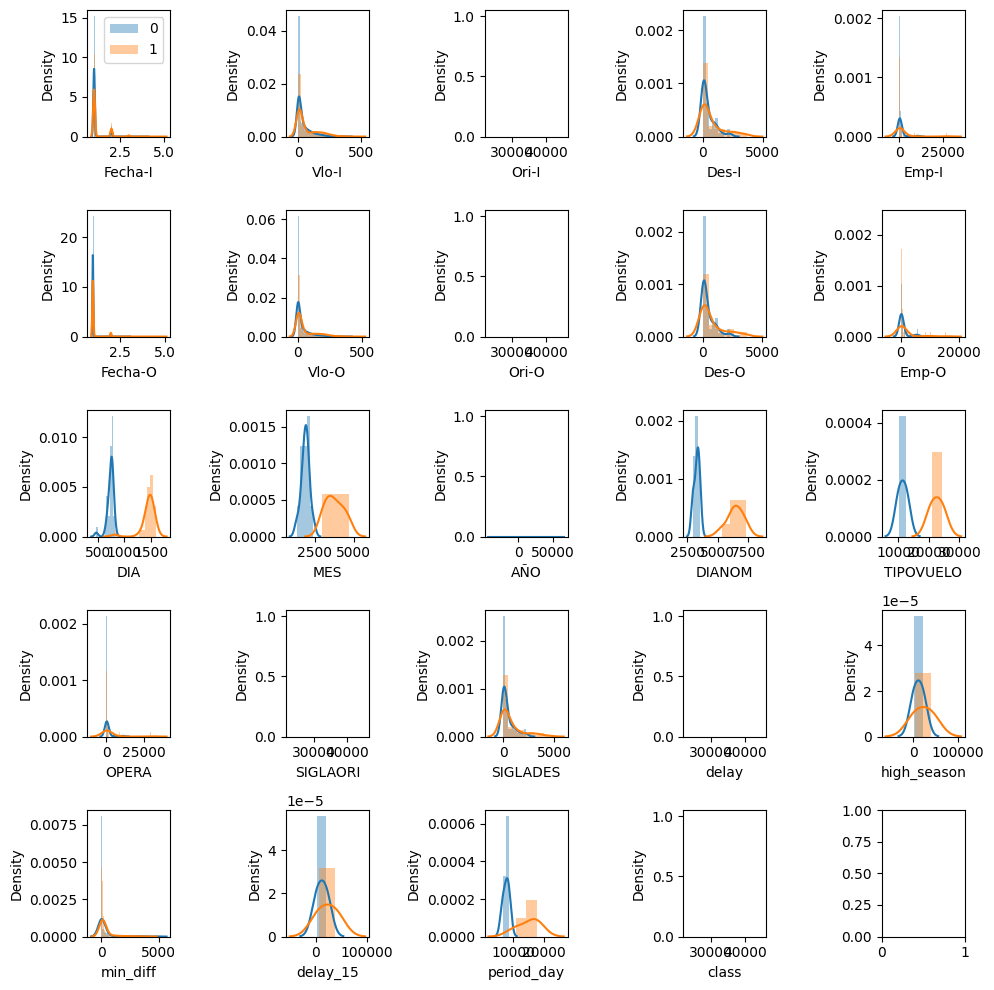

In [32]:
df_all = pd.DataFrame(df_train)
df_all['class'] = df_train['delay']
classes=np.unique(df_train['delay'].values)
plt.figure(figsize=(10, 10))
fig, axes = plt.subplots(figsize=(10,10), nrows=int(df_train.shape[1]/5+1), ncols=5)
for i, column in enumerate(df_train.columns):
    for class_ in classes:
      target = df_all.loc[df_all['class'] == class_]
      sns.distplot(target[column].value_counts(), hist=True, rug=False, kde=True, ax=axes[i//5,i%5],label=class_)
      if i==0:
        axes[0,0].legend()

plt.tight_layout()
plt.show()

Como vemos por los gráficos tanto la Fecha-I, Vlo-I, Des-I, Emp-I como Fecha-O, Vlo-O, Des-O, Emp-O, OPERA, SIGLADES, min_diff, high_season, delay_15 son variables que pueden influir de manera significativa en el delay. Las otras variables podríamos decir que son independientes de delay pues la densidad de distribución no se comporta como la de delay. Más adelante indicaremos con mayor claridad que variables influyen con mayor peso en cada modelo.

# 4. Train one or several models (using the algorithm(s) of your choice) to estimate the likelihood of a flight delay.

## Entrenamiento de modelos

Notemos que el conjunto de datos esta desbalanceado

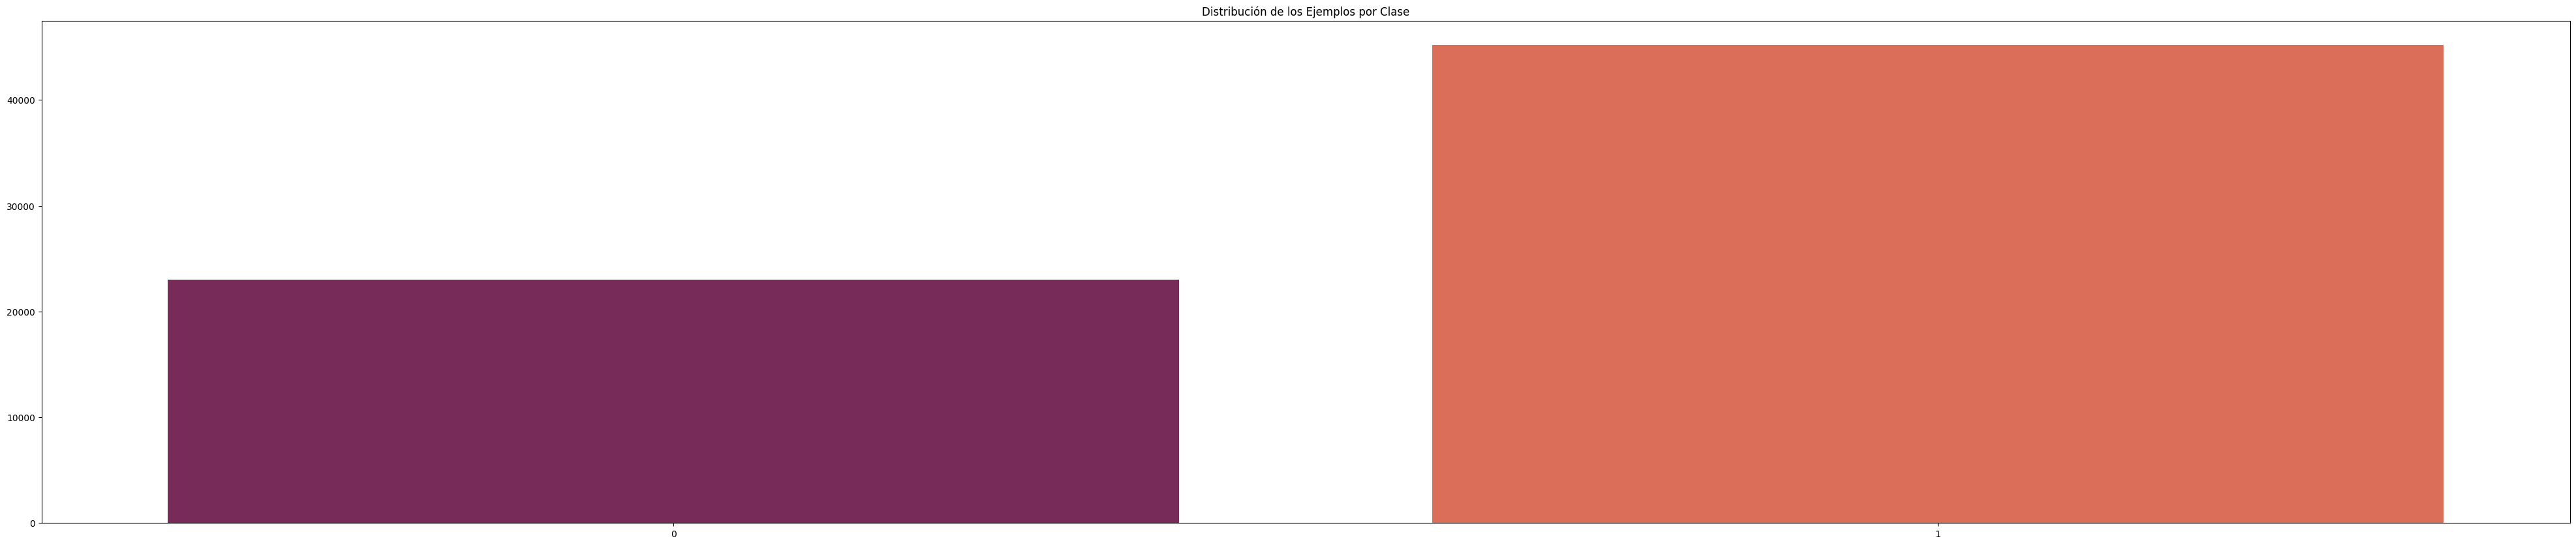

In [ ]:
clases, frecuencia = np.unique(df_train['delay'], return_counts=True)

fig, ax = plt.subplots(figsize=(50,10),nrows=1)
p = sns.barplot(x=clases, y=frecuencia, palette="rocket",ax=ax)
ax.set_title('Distribución de los Ejemplos por Clase')
plt.show()

In [ ]:
df_dummies = pd.get_dummies(df_train)

In [ ]:
df_dummies

,Fecha-I,Fecha-O,DIA,MES,AÑO,delay,class,high_season,min_diff,delay_15,...,SIGLADES_Sydney,SIGLADES_Temuco,SIGLADES_Toronto,SIGLADES_Tucuman,SIGLADES_Ushuia,SIGLADES_Valdivia,SIGLADES_Washington,period_day_afternoon,period_day_morning,period_day_night
0,2017-01-01 23:30:00,2017-01-01 23:33:00,1,1,2017,1,1,0,3,0,...,0,0,0,0,0,0,0,0,0,1
1,2017-01-02 23:30:00,2017-01-02 23:39:00,2,1,2017,1,1,0,9,0,...,0,0,0,0,0,0,0,0,0,1
2,2017-01-03 23:30:00,2017-01-03 23:39:00,3,1,2017,1,1,0,9,0,...,0,0,0,0,0,0,0,0,0,1
3,2017-01-04 23:30:00,2017-01-04 23:33:00,4,1,2017,1,1,0,3,0,...,0,0,0,0,0,0,0,0,0,1
4,2017-01-05 23:30:00,2017-01-05 23:28:00,5,1,2017,0,0,0,-2,0,...,0,0,0,0,0,0,0,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
68201,2017-12-22 14:55:00,2017-12-22 15:41:00,22,12,2017,1,1,0,-14,0,...,0,0,0,0,0,0,0,1,0,0
68202,2017-12-25 14:55:00,2017-12-25 15:11:00,25,12,2017,1,1,0,-44,0,...,0,0,0,0,0,0,0,1,0,0
68203,2017-12-27 14:55:00,2017-12-27 15:35:00,27,12,2017,1,1,0,-20,0,...,0,0,0,0,0,0,0,1,0,0
68204,2017-12-29 14:55:00,2017-12-29 15:08:00,29,12,2017,1,1,0,-47,0,...,0,0,0,0,0,0,0,1,0,0


In [ ]:
lista_fecha_I = ['Año-I','Mes-I','Dia-I','Hora-I','Minuto-I','Segundo-I']
lista_fecha_O = ['Año-O','Mes-O','Dia-O','Hora-O','Minuto-O','Segundo-O']
cont=0
for columna in lista_fecha_I:
  df_dummies[columna] = df.apply(lambda x: list(x['Fecha-I'].timetuple())[:6],axis=1).apply(lambda x: x[cont])
  cont+=1
cont=0
for columna in lista_fecha_O:
  df_dummies[columna] = df.apply(lambda x: list(x['Fecha-O'].timetuple())[:6],axis=1).apply(lambda x: x[cont])
  cont+=1

In [ ]:
df_dummies

,Fecha-I,Fecha-O,DIA,MES,AÑO,delay,class,high_season,min_diff,delay_15,...,Dia-I,Hora-I,Minuto-I,Segundo-I,Año-O,Mes-O,Dia-O,Hora-O,Minuto-O,Segundo-O
0,2017-01-01 23:30:00,2017-01-01 23:33:00,1,1,2017,1,1,0,3,0,...,1,23,30,0,2017,1,1,23,33,0
1,2017-01-02 23:30:00,2017-01-02 23:39:00,2,1,2017,1,1,0,9,0,...,2,23,30,0,2017,1,2,23,39,0
2,2017-01-03 23:30:00,2017-01-03 23:39:00,3,1,2017,1,1,0,9,0,...,3,23,30,0,2017,1,3,23,39,0
3,2017-01-04 23:30:00,2017-01-04 23:33:00,4,1,2017,1,1,0,3,0,...,4,23,30,0,2017,1,4,23,33,0
4,2017-01-05 23:30:00,2017-01-05 23:28:00,5,1,2017,0,0,0,-2,0,...,5,23,30,0,2017,1,5,23,28,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
68201,2017-12-22 14:55:00,2017-12-22 15:41:00,22,12,2017,1,1,0,-14,0,...,22,14,55,0,2017,12,22,15,41,0
68202,2017-12-25 14:55:00,2017-12-25 15:11:00,25,12,2017,1,1,0,-44,0,...,25,14,55,0,2017,12,25,15,11,0
68203,2017-12-27 14:55:00,2017-12-27 15:35:00,27,12,2017,1,1,0,-20,0,...,27,14,55,0,2017,12,27,15,35,0
68204,2017-12-29 14:55:00,2017-12-29 15:08:00,29,12,2017,1,1,0,-47,0,...,29,14,55,0,2017,12,29,15,8,0


In [ ]:
X = df_dummies.drop(columns=['class','delay','Fecha-I','Fecha-O']).values
y = df_dummies['delay'].values

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=0.2,random_state=1)

## Métricas
- Accuracy: Métrica estándar para problemas de clasificación
- F1-Score: En caso de un conjunto de datos desbalanceado, esta métrica es adecuada
- Recall: Cuantos elementos correctos se encontraron en el conjunto de datos en comparación a los reales
- Precision: Proporción de verdaderos positivos sobre predicciones positivas

## Logistic Regression

In [ ]:
model = LogisticRegression(random_state=1,class_weight='balanced')
param = {'penalty':['l1', 'l2'],'solver':['lbfgs']}
LR_CV = GridSearchCV(model,param,verbose=2,scoring='accuracy')
LR_CV.fit(X_train,y_train)

Fitting 5 folds for each of 2 candidates, totalling 10 fits
[CV] END ...........................penalty=l1, solver=lbfgs; total time=   0.7s
[CV] END ...........................penalty=l1, solver=lbfgs; total time=   0.7s
[CV] END ...........................penalty=l1, solver=lbfgs; total time=   0.7s
[CV] END ...........................penalty=l1, solver=lbfgs; total time=   0.7s
[CV] END ...........................penalty=l1, solver=lbfgs; total time=   0.9s
[CV] END ...........................penalty=l2, solver=lbfgs; total time=  26.9s
[CV] END ...........................penalty=l2, solver=lbfgs; total time=  23.0s
[CV] END ...........................penalty=l2, solver=lbfgs; total time=  22.5s
[CV] END ...........................penalty=l2, solver=lbfgs; total time=  22.6s
[CV] END ...........................penalty=l2, solver=lbfgs; total time=  21.7s


GridSearchCV(estimator=LogisticRegression(class_weight='balanced',
                                          random_state=1),
             param_grid={'penalty': ['l1', 'l2'], 'solver': ['lbfgs']},
             scoring='accuracy', verbose=2)

In [ ]:
df_metrics_1 = pd.DataFrame(index=[0])
df_metrics_1['Accuracy'] = accuracy_score(LR_CV.best_estimator_.predict(X_test),y_test)
df_metrics_1['F1-Score'] = f1_score(LR_CV.best_estimator_.predict(X_test),y_test)
df_metrics_1['Recall'] = recall_score(LR_CV.best_estimator_.predict(X_test),y_test)
df_metrics_1['Precision'] = precision_score(LR_CV.best_estimator_.predict(X_test),y_test)

In [ ]:
df_metrics_1

,Accuracy,F1-Score,Recall,Precision
0,0.656722,0.732843,0.763098,0.704895


In [ ]:
cm = confusion_matrix(y_test, LR_CV.best_estimator_.predict(X_test), labels=[0,1])
disp = ConfusionMatrixDisplay(confusion_matrix=cm,
                              display_labels=[0,1])

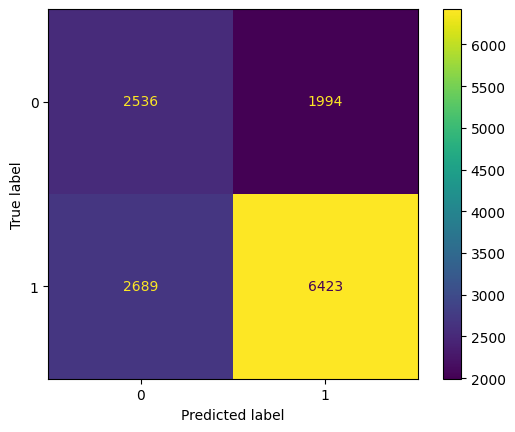

In [ ]:
disp.plot()
plt.show()

## Random Forest

In [ ]:
model_2 = RandomForestClassifier(random_state=1,class_weight='balanced')
param_2 = {'criterion':['gini', 'entropy', 'log_loss']}
RF_CV = GridSearchCV(model_2,param_2,verbose=2,scoring='accuracy')
RF_CV.fit(X_train,y_train)

Fitting 5 folds for each of 3 candidates, totalling 15 fits
[CV] END .....................................criterion=gini; total time= 1.0min
[CV] END .....................................criterion=gini; total time=  52.9s
[CV] END .....................................criterion=gini; total time=  56.1s
[CV] END .....................................criterion=gini; total time=  54.3s
[CV] END .....................................criterion=gini; total time=  55.9s
[CV] END ..................................criterion=entropy; total time=  55.2s
[CV] END ..................................criterion=entropy; total time=  56.9s
[CV] END ..................................criterion=entropy; total time=  56.8s
[CV] END ..................................criterion=entropy; total time=  54.8s
[CV] END ..................................criterion=entropy; total time=  55.9s
[CV] END .................................criterion=log_loss; total time=  58.2s
[CV] END .................................criteri

GridSearchCV(estimator=RandomForestClassifier(class_weight='balanced',
                                              random_state=1),
             param_grid={'criterion': ['gini', 'entropy', 'log_loss']},
             scoring='accuracy', verbose=2)

In [ ]:
df_metrics_2 = pd.DataFrame(index=[0])
df_metrics_2['Accuracy'] = accuracy_score(RF_CV.best_estimator_.predict(X_test),y_test)
df_metrics_2['F1-Score'] = f1_score(RF_CV.best_estimator_.predict(X_test),y_test)
df_metrics_2['Recall'] = recall_score(RF_CV.best_estimator_.predict(X_test),y_test)
df_metrics_2['Precision'] = precision_score(RF_CV.best_estimator_.predict(X_test),y_test)

In [ ]:
df_metrics_2

,Accuracy,F1-Score,Recall,Precision
0,0.97581,0.981892,0.981892,0.981892


In [ ]:
cm = confusion_matrix(y_test, RF_CV.best_estimator_.predict(X_test), labels=[0,1])
disp = ConfusionMatrixDisplay(confusion_matrix=cm,
                              display_labels=[0,1])

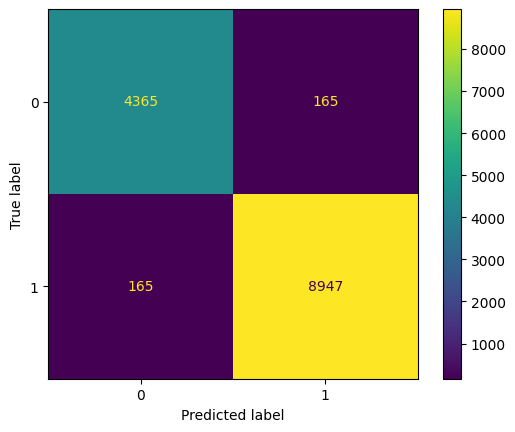

In [ ]:
disp.plot()
plt.show()

## Decision Tree Classifier

In [ ]:
model_3 = DecisionTreeClassifier(random_state=1,class_weight='balanced')
param_3 = {'criterion':['gini', 'entropy', 'log_loss']}
DT_CV = GridSearchCV(model_3,param_3,verbose=2,scoring='accuracy')
DT_CV.fit(X_train,y_train)

Fitting 5 folds for each of 3 candidates, totalling 15 fits
[CV] END .....................................criterion=gini; total time=  22.7s
[CV] END .....................................criterion=gini; total time=  22.6s
[CV] END .....................................criterion=gini; total time=  20.2s
[CV] END .....................................criterion=gini; total time=  21.8s
[CV] END .....................................criterion=gini; total time=  21.9s
[CV] END ..................................criterion=entropy; total time=   8.7s
[CV] END ..................................criterion=entropy; total time=   6.9s
[CV] END ..................................criterion=entropy; total time=   8.3s
[CV] END ..................................criterion=entropy; total time=   9.6s
[CV] END ..................................criterion=entropy; total time=   6.4s
[CV] END .................................criterion=log_loss; total time=   9.4s
[CV] END .................................criteri

GridSearchCV(estimator=DecisionTreeClassifier(class_weight='balanced',
                                              random_state=1),
             param_grid={'criterion': ['gini', 'entropy', 'log_loss']},
             scoring='accuracy', verbose=2)

In [ ]:
df_metrics_3 = pd.DataFrame(index=[0])
df_metrics_3['Accuracy'] = accuracy_score(DT_CV.best_estimator_.predict(X_test),y_test)
df_metrics_3['F1-Score'] = f1_score(DT_CV.best_estimator_.predict(X_test),y_test)
df_metrics_3['Recall'] = recall_score(DT_CV.best_estimator_.predict(X_test),y_test)
df_metrics_3['Precision'] = precision_score(DT_CV.best_estimator_.predict(X_test),y_test)

In [ ]:
df_metrics_3

,Accuracy,F1-Score,Recall,Precision
0,0.986146,0.989628,0.989683,0.989574


In [ ]:
cm = confusion_matrix(y_test, DT_CV.best_estimator_.predict(X_test), labels=[0,1])
disp = ConfusionMatrixDisplay(confusion_matrix=cm,
                              display_labels=[0,1])

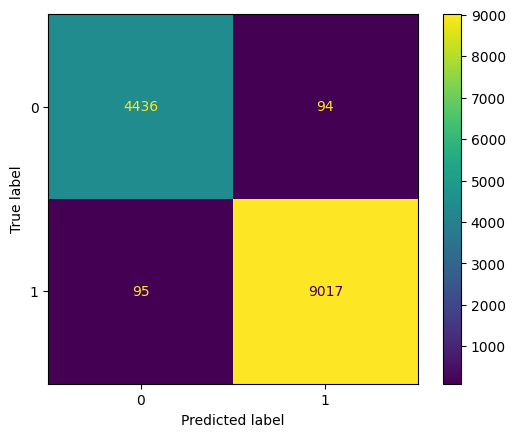

In [ ]:
disp.plot()
plt.show()

In [ ]:
df_metrics = pd.concat([df_metrics_1,df_metrics_2,df_metrics_3],axis=0)
df_metrics['Model'] = ['Logisitc Regression','Random Forest','Decision Tree Classifier']

# Evaluate model performance in the predictive task across each model that you trained. Define and justify what metrics you used to assess model performance. Pick the best trained model and evaluate the following: 
- What variables were the most influential in
the prediction task? 
- How could you improve the
Performance?

In [ ]:
df_metrics

,Accuracy,F1-Score,Recall,Precision,Model
0,0.656722,0.732843,0.763098,0.704895,Logisitc Regression
0,0.975810,0.981892,0.981892,0.981892,Random Forest
0,0.986146,0.989628,0.989683,0.989574,Decision Tree Classifier


## Decision Tree Classifier feature importance

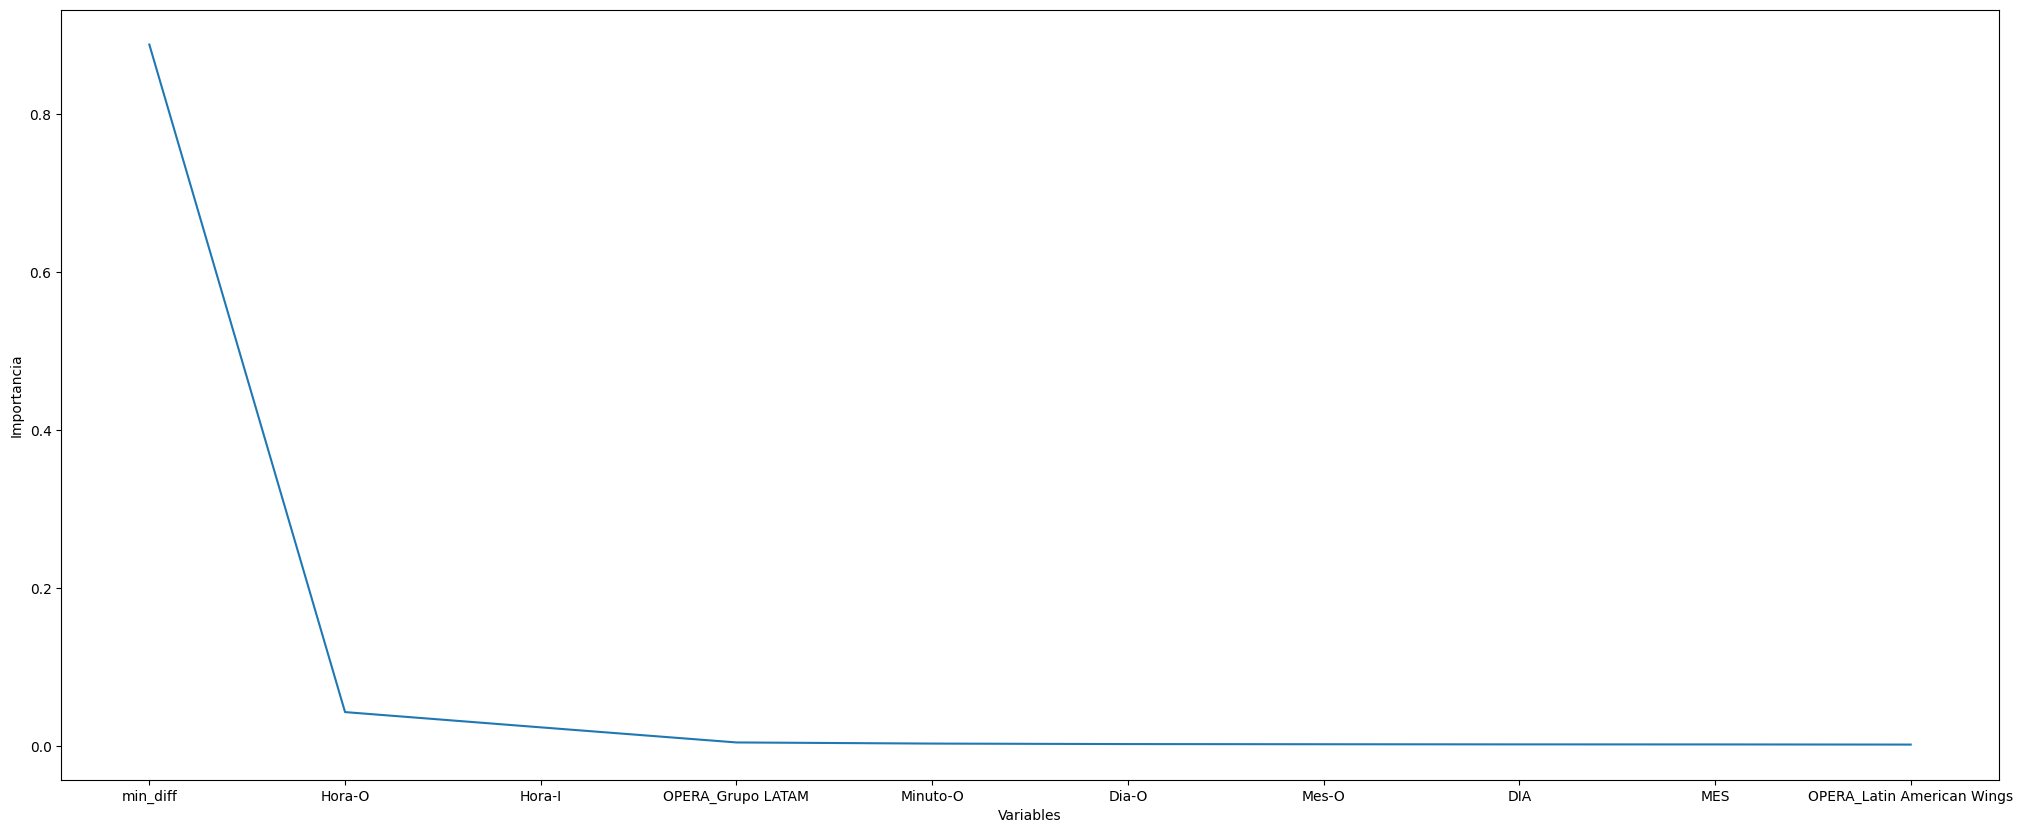

In [ ]:
plt.figure(figsize=(25,10))
variables = df_dummies.drop(columns=['class','delay','Fecha-I','Fecha-O']).columns[np.argsort(DT_CV.best_estimator_.feature_importances_)[::-1][:10]]
valores = np.sort(DT_CV.best_estimator_.feature_importances_)[::-1][:10]
plt.plot(variables,valores)
plt.xlabel('Variables')
plt.ylabel('Importancia')
plt.show()

Podríamos incrementar el rendimiento del modelo añadiendo mas hiperparámetros en GridSearchCV, pero significa más tiempo de ejecución. También como todo problema de Machine Learning mientras más datos tengamos a dispocisión mejor sera su desempeño por lo que tener más datos es crucial. Por último si los datos llegan a ser masivos podríamos optar por un enfoque de redes neuronales para resolver este problema.